In [1]:
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [2]:
data_dir = r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset'

img_size = (224, 224)
batch_size = 8

def load_and_preprocess_data(subdir_name):
    images = []
    labels = []
    
    class_counts = {}

    class_folders = os.listdir(os.path.join(data_dir, subdir_name))
    num_classes = len(class_folders)

    for class_index, class_folder in enumerate(class_folders):
        class_path = os.path.join(data_dir, subdir_name, class_folder)
        num_samples = len(os.listdir(class_path))
        class_counts[class_folder] = num_samples

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            img = load_img(image_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array /= 255.0
            images.append(img_array)
            labels.append(class_index)
    images = np.array(images)
    labels = to_categorical(labels, num_classes=num_classes)

    print("Class Representation:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} samples")

    return images, labels, num_classes, class_counts

In [5]:
images, labels, num_classes, class_counts = load_and_preprocess_data('train')
train_images, valid_images, train_labels, valid_labels = train_test_split(images, labels, test_size=0.242, random_state=42)

Class Representation:
Audi: 814 samples
Hyundai Creta: 271 samples
Mahindra Scorpio: 316 samples
Rolls Royce: 311 samples
Swift: 424 samples
Tata Safari: 441 samples
Toyota Innova: 775 samples


In [7]:
class_weights = {}
total_samples = len(train_labels)
for class_index in range(num_classes):
    class_count = np.sum(train_labels[:, class_index])
    class_weight = total_samples / (num_classes * class_count)
    class_weights[class_index] = class_weight

base_model = MobileNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )  

early_stopping = EarlyStopping(monitor="val_accuracy", patience=5, verbose=1, min_delta=0.01, restore_best_weights=True)

history = model.fit(
    train_images,
    train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=batch_size,
    epochs=20,
    callbacks=[early_stopping],
    class_weight=class_weights
)

Epoch 1/20
318/318 [==============================] - 12s 21ms/step - loss: 0.9189 - accuracy: 0.7012 - val_loss: 0.5350 - val_accuracy: 0.8005
Epoch 2/20
318/318 [==============================] - 5s 15ms/step - loss: 0.3941 - accuracy: 0.8685 - val_loss: 0.7398 - val_accuracy: 0.7475
Epoch 3/20
318/318 [==============================] - 5s 15ms/step - loss: 0.2200 - accuracy: 0.9295 - val_loss: 0.3658 - val_accuracy: 0.8793
Epoch 4/20
318/318 [==============================] - 5s 15ms/step - loss: 0.1415 - accuracy: 0.9516 - val_loss: 0.5084 - val_accuracy: 0.8448
Epoch 5/20
318/318 [==============================] - 5s 15ms/step - loss: 0.0836 - accuracy: 0.9693 - val_loss: 0.4791 - val_accuracy: 0.8670
Epoch 6/20
318/318 [==============================] - 5s 15ms/step - loss: 0.0566 - accuracy: 0.9791 - val_loss: 0.4662 - val_accuracy: 0.8793
Epoch 7/20
318/318 [==============================] - 5s 15ms/step - loss: 0.0777 - accuracy: 0.9673 - val_loss: 0.5158 - val_accuracy: 0.867

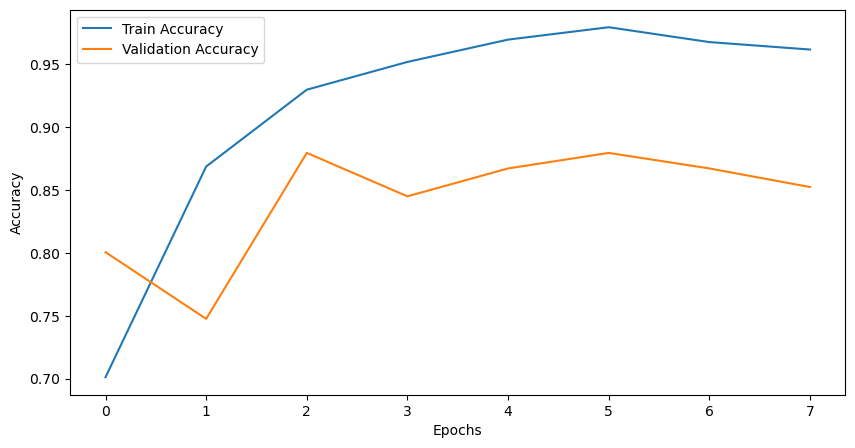

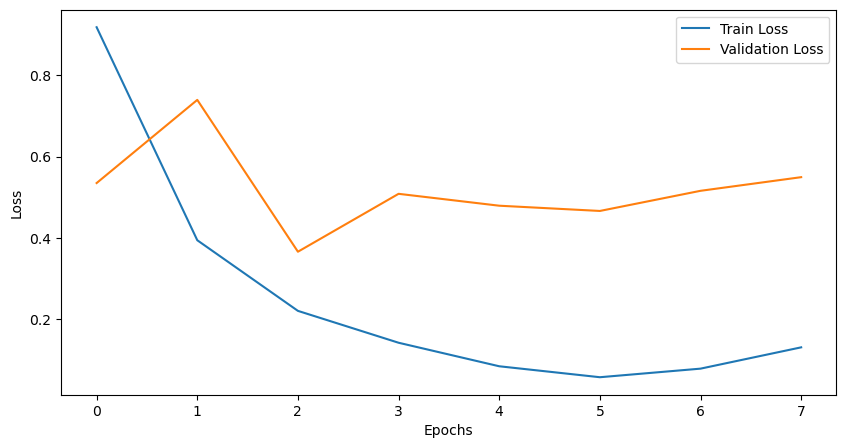

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
test_images, test_labels, num_classes, class_counts_test = load_and_preprocess_data('test')

test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

confusion_matrix_array = confusion_matrix(true_classes, test_predictions_classes)

class_names = [str(i) for i in range(num_classes)]
classification_rep = classification_report(true_classes, test_predictions_classes, target_names=class_names)
print("Classification Report:\n", classification_rep)


Class Representation:
Audi: 199 samples
Hyundai Creta: 67 samples
Mahindra Scorpio: 75 samples
Rolls Royce: 74 samples
Swift: 102 samples
Tata Safari: 106 samples
Toyota Innova: 190 samples
26/26 [==============================] - 1s 33ms/step - loss: 0.3173 - accuracy: 0.8918
Test Loss: 0.31729406118392944
Test Accuracy: 0.891758918762207
26/26 [==============================] - 2s 31ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       199
           1       0.79      0.84      0.81        67
           2       0.89      0.93      0.91        75
           3       0.79      0.84      0.82        74
           4       0.88      0.89      0.89       102
           5       0.91      0.87      0.89       106
           6       0.96      0.93      0.94       190

    accuracy                           0.89       813
   macro avg       0.87      0.88      0.88       813
weighted avg       0.89      0.89     

<AxesSubplot:>

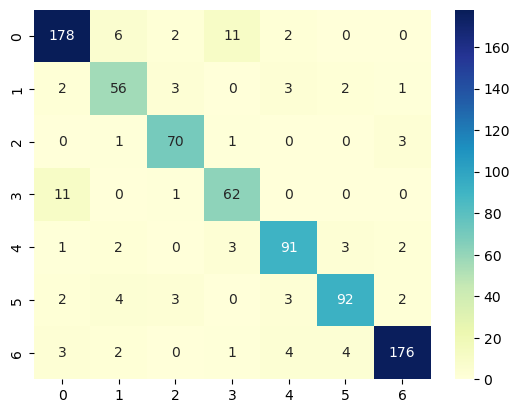

In [10]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_matrix_array, range(7), range(7))
sn.heatmap(df_cm, annot=True,fmt="d", cmap="YlGnBu")

In [11]:
classification_dict = classification_report(true_classes, test_predictions_classes, target_names=class_names, output_dict=True)
classification_df = pd.DataFrame(classification_dict).transpose()

excel_path = os.path.join(r'C:\Users\haris\AI\ML\Projects\Data\Cars Dataset', 'classification_report.xlsx')
classification_df.to_excel(excel_path, index=True)

print(f"Classification report saved as Excel to {excel_path}")

Classification report saved as Excel to C:\Users\haris\AI\ML\Projects\Data\Cars Dataset\classification_report.xlsx


In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           